В этот раз нам предстоит решать задачу предсказания уровня заработной платы человека: больше она 50 тыс. долл. в год, или нет. <br>
Более формально, перед нами задача бинарной классификации (ЗП > 50 тыс долл, ЗП < 50 тыс долл). 

In [1]:
# импортируем библиотеки для работы с данными и эффективных численных операций
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# импортируем нужные нам модели случайного леса и градиентного бустинга над решающими деревьями
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [3]:
# импортируем нужные нам модули для кросс-валидации
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
RANDOM_STATE = 257

Фукнция read_csv из библиотеки pandas позволяет считать файл в формате csv (от англ. Comma-Separated Values — значения, разделённые запятыми). Во многих задачах данные хранятся именно в таком формате, так что эту функцию вам придется использовать довольно часто. <br><br>
***Важно!*** Убедитесь что данные лежат у вас в нужной папке: данные должны быть в той же директории, что и этот ноутбук, и лежать в под-директории data/boosting/

In [6]:
dataset = pd.read_csv('data/boosting/train.csv')

Помним, что важный этап анализа данных - визуализация, как графическая, так и табличная. Взглядем с помощью функции head() на первые 5 строчек в наших данных.

In [7]:
dataset.head()

,age,job,fnlwgt,education,educationNum,familyStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country,salaryLevel
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [8]:
# посмотрим, сколько у нас объектов и признаков
dataset.shape

(28998, 15)

Целевая переменная в этом датасете хранится в колонке salaryLevel. Сохраним ее в переменную y и преобразуем в удобный для алгоритмов формат. 

In [9]:
y = dataset['salaryLevel']
X = dataset.drop('salaryLevel', axis=1)

In [10]:
# превращаем наш целевой вектор в последовательность 0 и 1
y = y.apply(lambda x: 0 if x == ' <=50K' else 1)

### Изучение признаков и целевой переменной

Для начала посмотрим на распределение нашей целевой переменной

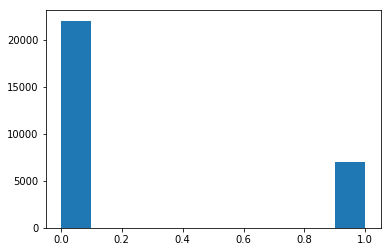

In [11]:
plt.hist(y);

Из названия признаков понятно, что большинство из них - категориальные, значит для корректной работы модели необходимо преобразовать их с помощью функции get_dummies из библиотеки pandas. Для начала глянем на распределение категориальных переменных.

In [12]:
categorial_variables = ['job', 'education', 'familyStatus', 'occupation', 'relationship', 'race', 'sex', 'country']

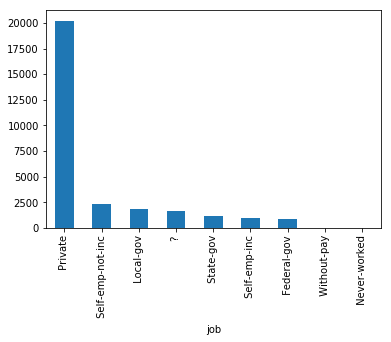

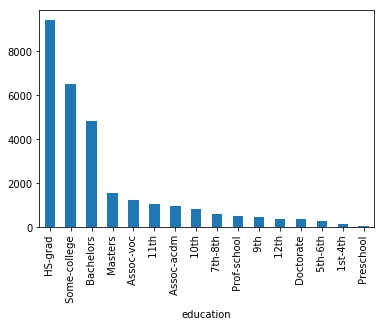

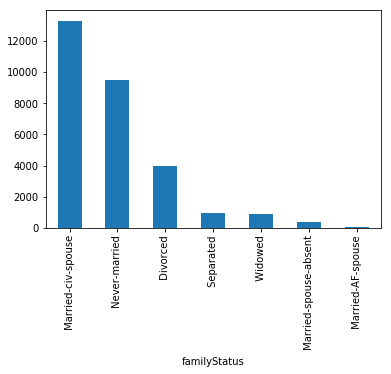

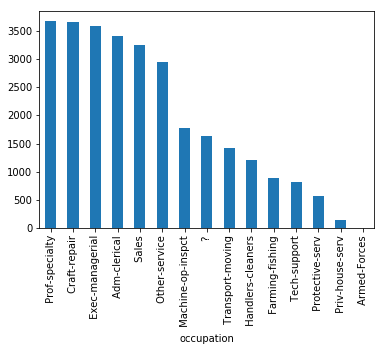

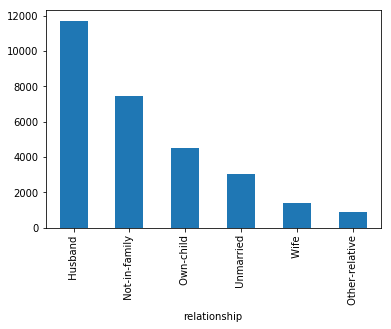

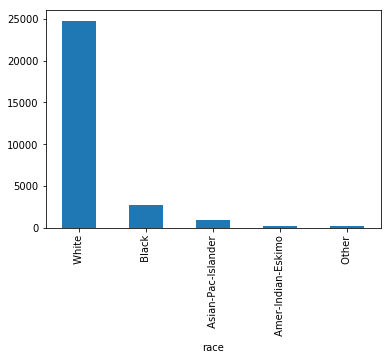

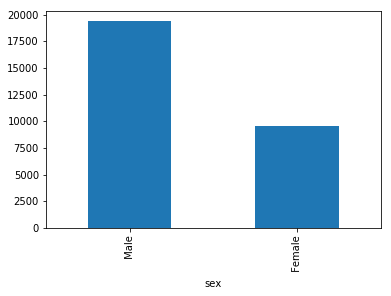

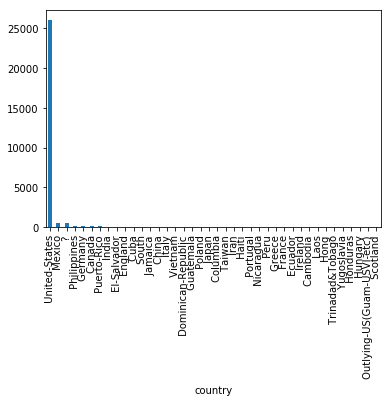

In [13]:
# распределение переменных
for column in categorial_variables:
    X[column].value_counts().plot(kind='bar');
    plt.xlabel(column);
    plt.show(); 

***Задание***: создайте лист, содержащий числовые признаки. У вас должно получиться 6 значений. Постройте распределение числовых признаков. 

In [14]:
continuous_variables = ['age', 'fnlwgt', 'educationNum', 'capitalGain', 'capitalLoss', 'hoursPerWeek']

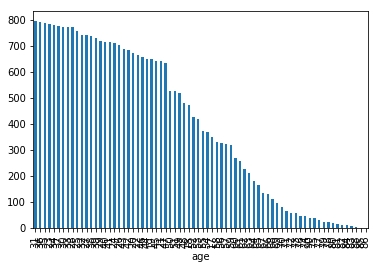

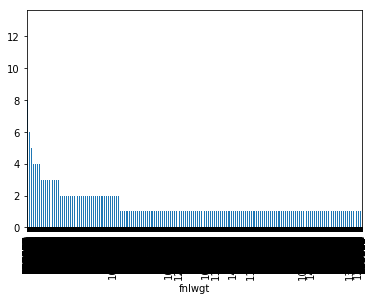

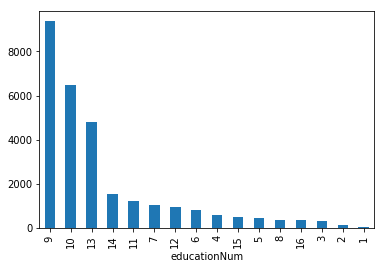

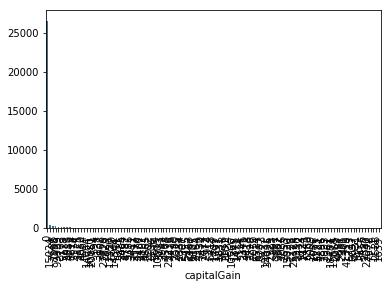

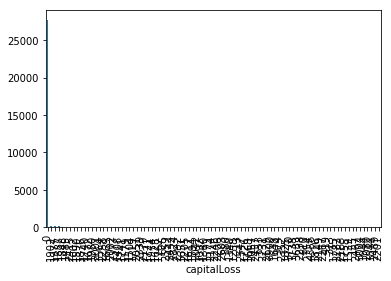

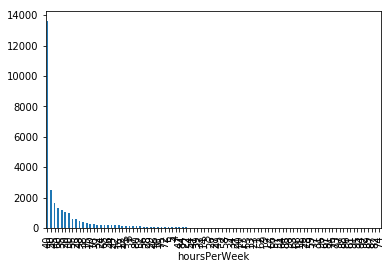

In [15]:
# код для того, чтобы построить распределение признаков
for column in continuous_variables:
    X[column].value_counts().plot(kind='bar');
    plt.xlabel(column);
    plt.show(); 

Закодируем категориальные переменные с помощью функции get_dummies и объединим все в один датафрейм

In [16]:
print(X.shape, 'before one hot encoding')
for column in categorial_variables:
    X = pd.concat([X, pd.get_dummies(X[column])], axis=1)
print(X.shape, 'after one hot encoding')    

(28998, 14) before one hot encoding
(28998, 114) after one hot encoding


Теперь нам осталось только удалить оригинальные столбцы категориальных переменных, после чего можно переходить к построению моделей!

In [17]:
X.drop(categorial_variables, axis=1, inplace=True)
print(X.shape, 'after dropping')

(28998, 106) after dropping


In [18]:
X.head()

,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek,?,Federal-gov,Local-gov,Never-worked,...,Poland,Portugal,Puerto-Rico,Scotland,South,Taiwan,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Построение модели случайного леса. Зависимость точности от количества деревьев. 

Для начала настроим стратегию валидации. В качестве стратегии выберем деление на обучение и тест в пропорции 75 на 25 (test_size=0.25), при этом перемешав обучающую выборку (shuffle=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

In [20]:
n_estimators = [3, 5, 10, 30, 50, 70, 100, 120, 150, 200, 250, 270, 290, 320]
accuracy_random_forest = []

for num in n_estimators:
    estimator = RandomForestClassifier(n_estimators=num, random_state=RANDOM_STATE)
    estimator.fit(X_train, y_train)
    accuracy_random_forest.append(
        accuracy_score(y_test, estimator.predict(X_test))
    )
    print(num, accuracy_random_forest[-1])

3 0.8326896551724138
5 0.8413793103448276
10 0.849103448275862
30 0.8542068965517241
50 0.856
70 0.8584827586206897
100 0.8557241379310345
120 0.856551724137931
150 0.8557241379310345
200 0.8550344827586207
250 0.8550344827586207
270 0.8562758620689656
290 0.8561379310344828
320 0.855448275862069


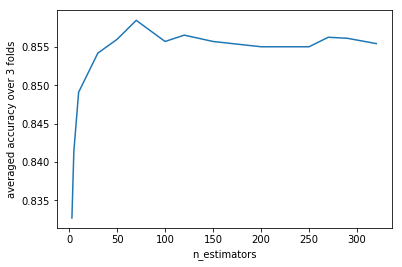

In [21]:
plt.plot(n_estimators, accuracy_random_forest);
plt.xlabel('n_estimators');
plt.ylabel('averaged accuracy over 3 folds');

In [22]:
max(accuracy_random_forest)

0.8584827586206897

### Построение модели градиентного бустинга над решающими деревьями. Зависимость точности от количества деревьев. 

In [23]:
n_estimators = [3, 5, 10, 30, 50, 70, 100, 120, 150, 200, 250, 270, 290, 320, 350, 380, 500]
accuracy_gradient_boosting = []

for num in n_estimators:
    estimator = LGBMClassifier(n_estimators=num, random_state=RANDOM_STATE)
    estimator.fit(X_train, y_train)
    accuracy_gradient_boosting.append(
        accuracy_score(y_test, estimator.predict(X_test))
    )
    print(num, accuracy_gradient_boosting[-1])

3 0.763448275862069
5 0.8230344827586207
10 0.8601379310344828
30 0.8762758620689656
50 0.8773793103448276
70 0.8782068965517241
100 0.8772413793103448
120 0.8764137931034482
150 0.876551724137931
200 0.8768275862068966
250 0.8742068965517241
270 0.8740689655172413
290 0.8737931034482759
320 0.8731034482758621
350 0.8728275862068966
380 0.871448275862069
500 0.8728275862068966


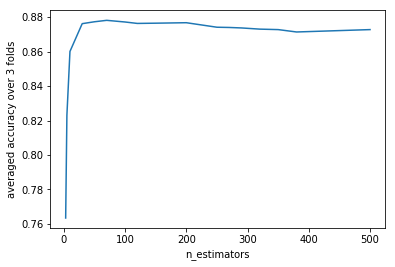

In [24]:
plt.plot(n_estimators, accuracy_gradient_boosting);
plt.xlabel('n_estimators');
plt.ylabel('averaged accuracy over 3 folds');

In [25]:
max(accuracy_gradient_boosting)

0.8782068965517241

### Grid search параметров градиентного бустинга: пример

***Важно***: перебор гиперпараметров модели может занимать значительное время (от нескольких до десятка минут), так что не стоит беспокоиться, что ваша программа зависла. 

In [26]:
n_estimators = [10, 30, 50, 70, 100, 120, 150, 200, 300]
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.2]
max_depths = [-1, 3, 5, 7, 10]
min_child_samples = [5, 15, 30]

stats = []
for num in n_estimators:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            for min_child_sample in min_child_samples:
                estimator = LGBMClassifier(
                    learning_rate=learning_rate, 
                    n_estimators=num, 
                    max_depth=max_depth,
                    min_child_samples=min_child_sample,
                    random_state=RANDOM_STATE
                )
                estimator.fit(X_train, y_train)
                stats.append({
                    'n_estimators': num,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth,
                    'min_child_samples': min_child_sample,
                    'mean_accuracy': accuracy_score(y_test, estimator.predict(X_test))
                })

Сформируем dataframe из параметров модели и значений целевой метрики на валидации. Посмотрим максимум и корреляцию accuracy с параметрами. 

In [27]:
stats_df = pd.DataFrame(stats)
stats_df.shape

(675, 5)

Узнаем максимальную точность на тесте, которую нам удалось достичь

In [28]:
stats_df['mean_accuracy'].max()

0.8806896551724138

Посмотрим корреляцию между оценкой точности и гиперпараметрами модели

In [29]:
stats_df.corr()['mean_accuracy']

learning_rate        0.560791
max_depth            0.016327
mean_accuracy        1.000000
min_child_samples   -0.000313
n_estimators         0.423782
Name: mean_accuracy, dtype: float64

Однако, вместо того, чтобы писать несколько вложенных циклов по каждому из параметров, можно воспользоваться очень удобной функцией GridSearchCV из библиотеки sklearn. <br>
Давайте для начала разберемся с функцией GridSearchCV. Что такое grid search мы разобрали. Что такое CV?<br>
CV -- cross-validation (кросс-валидация \ перекрестная оценка). Это процедура для более устойчивой оценки обобщающей способности алгоритма. До этого, мы использовали отложенную выборку, чтобы оценить то, насколько хорошо наша модель обобщает. По сути, мы делили все имеющееся у нас множество на две части: обучение и тест. <br>
Кросс-валидация предлагает другой подход: мы делим наше множество на несколько равных частей (обычно они называются фолдами). Например, мы разделили наше множество на три равные части. <br>
После этого, мы делаем следующее: мы используем первые две части для обучения, а третью для теста. Получили оценку точности и обученную модель. <br>
Затем, обучаем новую модель на первой и третьей части нашего множества, а вторую используем как тест. <br>
И еще раз повторяем процедуру: учим новую модель на 2 и 3ей части, 1ую используем для валидации. <br>
Таким образом, мы получим аж 3 оценки точности на разных тестовых множествах. Теперь наши суждения о обобщающей способности алгоритма будут более точными. <br>
Такой подход называется K-Fold cross validation. К - это количество частей, на которые мы бьем наше множество. В предыдущем примере K = 3.

In [30]:
# задаем стратегию кросс-валидации
cv = StratifiedKFold(n_splits=3, random_state=257, shuffle=True)

In [31]:
params_lgbm = {
    'n_estimators' : [10, 30, 50, 70, 100, 120, 150, 200, 300],
    'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth' : [-1, 3, 5, 7, 10],
    'min_child_samples' : [5, 15, 30]
}

grid_search_lgbm = GridSearchCV(LGBMClassifier(), param_grid=params_lgbm, cv=cv, n_jobs=1)
grid_search_lgbm.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=257, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [10, 30, 50, 70, 100, 120, 150, 200, 300], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2], 'max_depth': [-1, 3, 5, 7, 10], 'min_child_samples': [5, 15, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
grid_search_lgbm.best_score_, grid_search_lgbm.best_params_,

(0.8737499137871577,
 {'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_samples': 5,
  'n_estimators': 300})

### Random search параметров градиентного бустинга: пример

In [34]:

        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 
        importance_type='split', learning_rate=0.1, max_depth=-1,
 params_lgbm_random_seatch = {
    'n_estimators' : scipy.stats.randint(10, 200),
    'learning_rate' : scipy.stats.uniform(0.0005, 0.5),
    'max_depth' : scipy.stats.randint(1, 15),
    'min_child_samples' : scipy.stats.randint(2, 20),
}

random_search_lgbm = RandomizedSearchCV(
    LGBMClassifier(), param_distributions=params_lgbm_random_seatch, cv=cv, n_iter=50, n_jobs=1
)
random_search_lgbm.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=257, shuffle=True),
          error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd03f63ecf8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd049460da0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0494609e8>, 'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 

In [35]:
random_search_lgbm.best_score_, random_search_lgbm.best_params_

(0.8725429339954479,
 {'learning_rate': 0.05857541427678298,
  'max_depth': 10,
  'min_child_samples': 4,
  'n_estimators': 112})

***Задание***: напишите grid search параметров случайного леса. Модель с лучшими параметрами используйте для предсказания на тестовом множестве. Результат предсказаний передайте в специальную функцию convert_predictions(), вывод функции скопируйте и отправьте в edx. <br>

In [36]:
def convert_predictions(predictions):
    print(','.join([str(x) for x in predictions]))

In [38]:
# ваш код для grid search параметров случайного леса
params_rf = {
    'n_estimators' : [10, 30, 50, 70, 100, 120, 150, 200, 300],
    'max_depth' : [3, 5, 7, 10, 15],
    'min_samples_leaf' : [1, 5, 15, 30]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=params_rf, cv=cv, n_jobs=1)
grid_search_rf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=257, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [10, 30, 50, 70, 100, 120, 150, 200, 300], 'max_depth': [3, 5, 7, 10, 15], 'min_samples_leaf': [1, 5, 15, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
# ваш код для grid search параметров случайного леса
grid_search_rf.best_score_

0.8624043037450859

In [49]:
# ваш код для grid search параметров случайного леса
grid_search_rf.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 120}

Считаем файл с тестовым множеством и обработаем данные: закодируем с помощью get_dummies категориальные переменные

In [41]:
test_dataset = pd.read_csv('data/boosting/test.csv')
test_dataset.head()

,age,job,fnlwgt,education,educationNum,familyStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country
0,22,Private,272615,11th,7,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States
1,31,Private,54318,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,27,Private,165519,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
3,45,Private,48495,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,42,United-States
4,38,Private,143123,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


In [42]:
test_X = test_dataset.copy()

In [43]:
print(test_X.shape, 'before one hot encoding')
for column in categorial_variables:
    test_X = pd.concat([test_X, pd.get_dummies(test_X[column])], axis=1)
print(test_X.shape, 'after one hot encoding')    

(3560, 14) before one hot encoding
(3560, 114) after one hot encoding


In [44]:
test_X.drop(categorial_variables, axis=1, inplace=True)
print(test_X.shape, 'after dropping')

(3560, 106) after dropping


Данные готовы для предсказания. Теперь ваша задача - предсказать с помощью вашей модели значение целевой переменной для датасета test_X и передать результат в качестве аргумента в функцию convert_predictions. Результат, который функция выведет на экран необходимо скопировать и вставить в edx.

In [50]:
convert_predictions(grid_search_rf.best_estimator_.predict(test_X))

0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

***Задание***: напишите random search параметров случайного леса.  Модель с лучшими параметрами используйте для предсказания на тестовом множестве. Результат предсказаний передайте в специальную функцию convert_predictions(), вывод функции скопируйте и отправьте в edx. 

In [52]:
# ваш код для random search параметров случайного леса
params_rf_random_search = {
    'n_estimators' : scipy.stats.randint(90, 190),
    'max_depth' : scipy.stats.randint(10, 25),
    'min_samples_leaf' : scipy.stats.randint(1, 5),
}

random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(), param_distributions=params_rf_random_search, cv=cv, n_iter=100, n_jobs=1
)
random_search_rf.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=257, shuffle=True),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0251dd160>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0251dda58>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0251dd080>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
 

In [53]:
# ваш код для random search параметров случайного леса
random_search_rf.best_score_, random_search_rf.best_params_

(0.8654389957928132,
 {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 106})

In [54]:
# ваш код для random search параметров случайного леса
estimator = random_search_rf.best_estimator_

Ваша задача - предсказать с помощью вашей модели значение целевой переменной для датасета test_X и передать результат в качестве аргумента в функцию convert_predictions. Результат, который функция выведет на экран необходимо скопировать и вставить в edx.

In [55]:
convert_predictions(estimator.predict(test_X))

0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,